In [2]:
import sys
print("Python version: {}".format(sys.version))
import pandas as pd
print("pandas version: {}".format(pd.__version__))
import numpy as np
print("NumPy version: {}".format(np.__version__))
import scipy as sp
print("SciPy version: {}".format(sp.__version__))
import IPython
print("IPython version: {}".format(IPython.__version__))
import sklearn
print("scikit-learn version: {}".format(sklearn.__version__))
import matplotlib.pyplot as plt
# Import seaborn
import seaborn as sns

Python version: 3.8.16 | packaged by conda-forge | (default, Feb  1 2023, 16:05:36) 
[Clang 14.0.6 ]
pandas version: 1.5.3
NumPy version: 1.24.2
SciPy version: 1.10.0
IPython version: 8.9.0
scikit-learn version: 1.2.2


CREAMOS UNA SESIÓN DE SPARK

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").appName("Customer Clustering")\
      .config("spark.some.config.option", "some-value")\
      .getOrCreate()

24/01/10 16:19:33 WARN Utils: Your hostname, MacBook-Pro-de-Rafael.local resolves to a loopback address: 127.0.0.1; using 10.5.61.97 instead (on interface en0)
24/01/10 16:19:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/01/10 16:19:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


IMPORTAMOS PANDAS PARA PREPROCESAR NUESTROS DATOS

In [4]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pyspark.pandas as ps

In [37]:
customer=pd.read_csv('/Users/rafaelotero/Desktop/Credit Card Customer Data.csv')

In [38]:
customer.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [39]:
customer.describe()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,330.500000,55141.443939,34574.242424,4.706061,2.403030,2.606061,3.583333
std,190.669872,25627.772200,37625.487804,2.167835,1.631813,2.935724,2.865317
min,1.000000,11265.000000,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,165.750000,33825.250000,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,330.500000,53874.500000,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,495.250000,77202.500000,48000.000000,6.000000,4.000000,4.000000,5.000000
max,660.000000,99843.000000,200000.000000,10.000000,5.000000,15.000000,10.000000


In [40]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [41]:
customer.isnull()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
655,False,False,False,False,False,False,False
656,False,False,False,False,False,False,False
657,False,False,False,False,False,False,False
658,False,False,False,False,False,False,False


ACABAMOS DE COMPROBAR QUE NO TENEMOS VALORES PERDIDOS

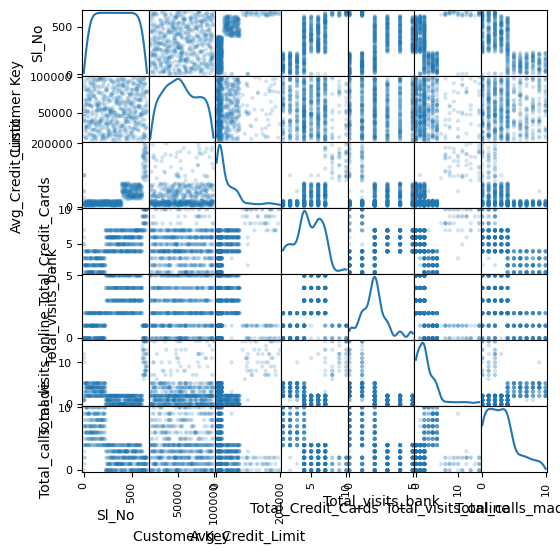

In [42]:
from pandas.plotting import scatter_matrix
scatter_matrix(customer, alpha=0.2, figsize=(6, 6), diagonal="kde");
plt.show()

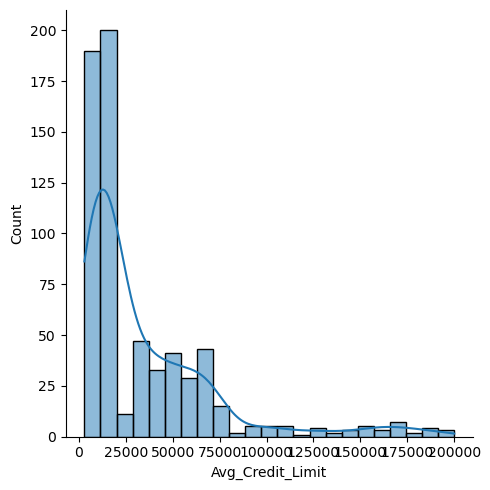

In [43]:
sns.displot(data=customer, x="Avg_Credit_Limit", kde=True)
plt.show()

ESTA ES LA DISTRIBUCIÓN DE LA VARIABLE Avg_Credit_Limit HECHA CON SEABORN. ES UNA GRÁFICA BASTANTE ILUSTRATIVA

IDEA: PODEMOS CREAR UNA NUEVA VARIABLE CATEGÓRICA QUE NOS INDIQUE QUE USUARIOS ESTÁN POR ENCIMA Y POR DEBAJO DE LA MEDIANA
DE LA VARIABLE Avg_Credit_Limit, Y VER CÓMO SE DISTRIBUYEN LAS DEMÁS VARIABLES SEGÚN ESTAS DOS CATEGORÍAS

In [44]:
#Definimos los percentiles

Q1 = customer["Avg_Credit_Limit"].quantile(0.25)
Q2 = customer["Avg_Credit_Limit"].quantile(0.50)
Q3 = customer["Avg_Credit_Limit"].quantile(0.75)

In [45]:
customer["Nivel_Credito_Medio"] = np.where(customer["Avg_Credit_Limit"] < Q1, "bajo", 
                                           np.where((customer["Avg_Credit_Limit"] >= Q1) & (customer["Avg_Credit_Limit"] <= Q3), 
                                                    "medio", "alto"))

In [46]:
customer.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Nivel_Credito_Medio
0,1,87073,100000,2,1,1,0,alto
1,2,38414,50000,3,0,10,9,alto
2,3,17341,50000,7,1,3,4,alto
3,4,40496,30000,5,1,1,4,medio
4,5,47437,100000,6,0,12,3,alto


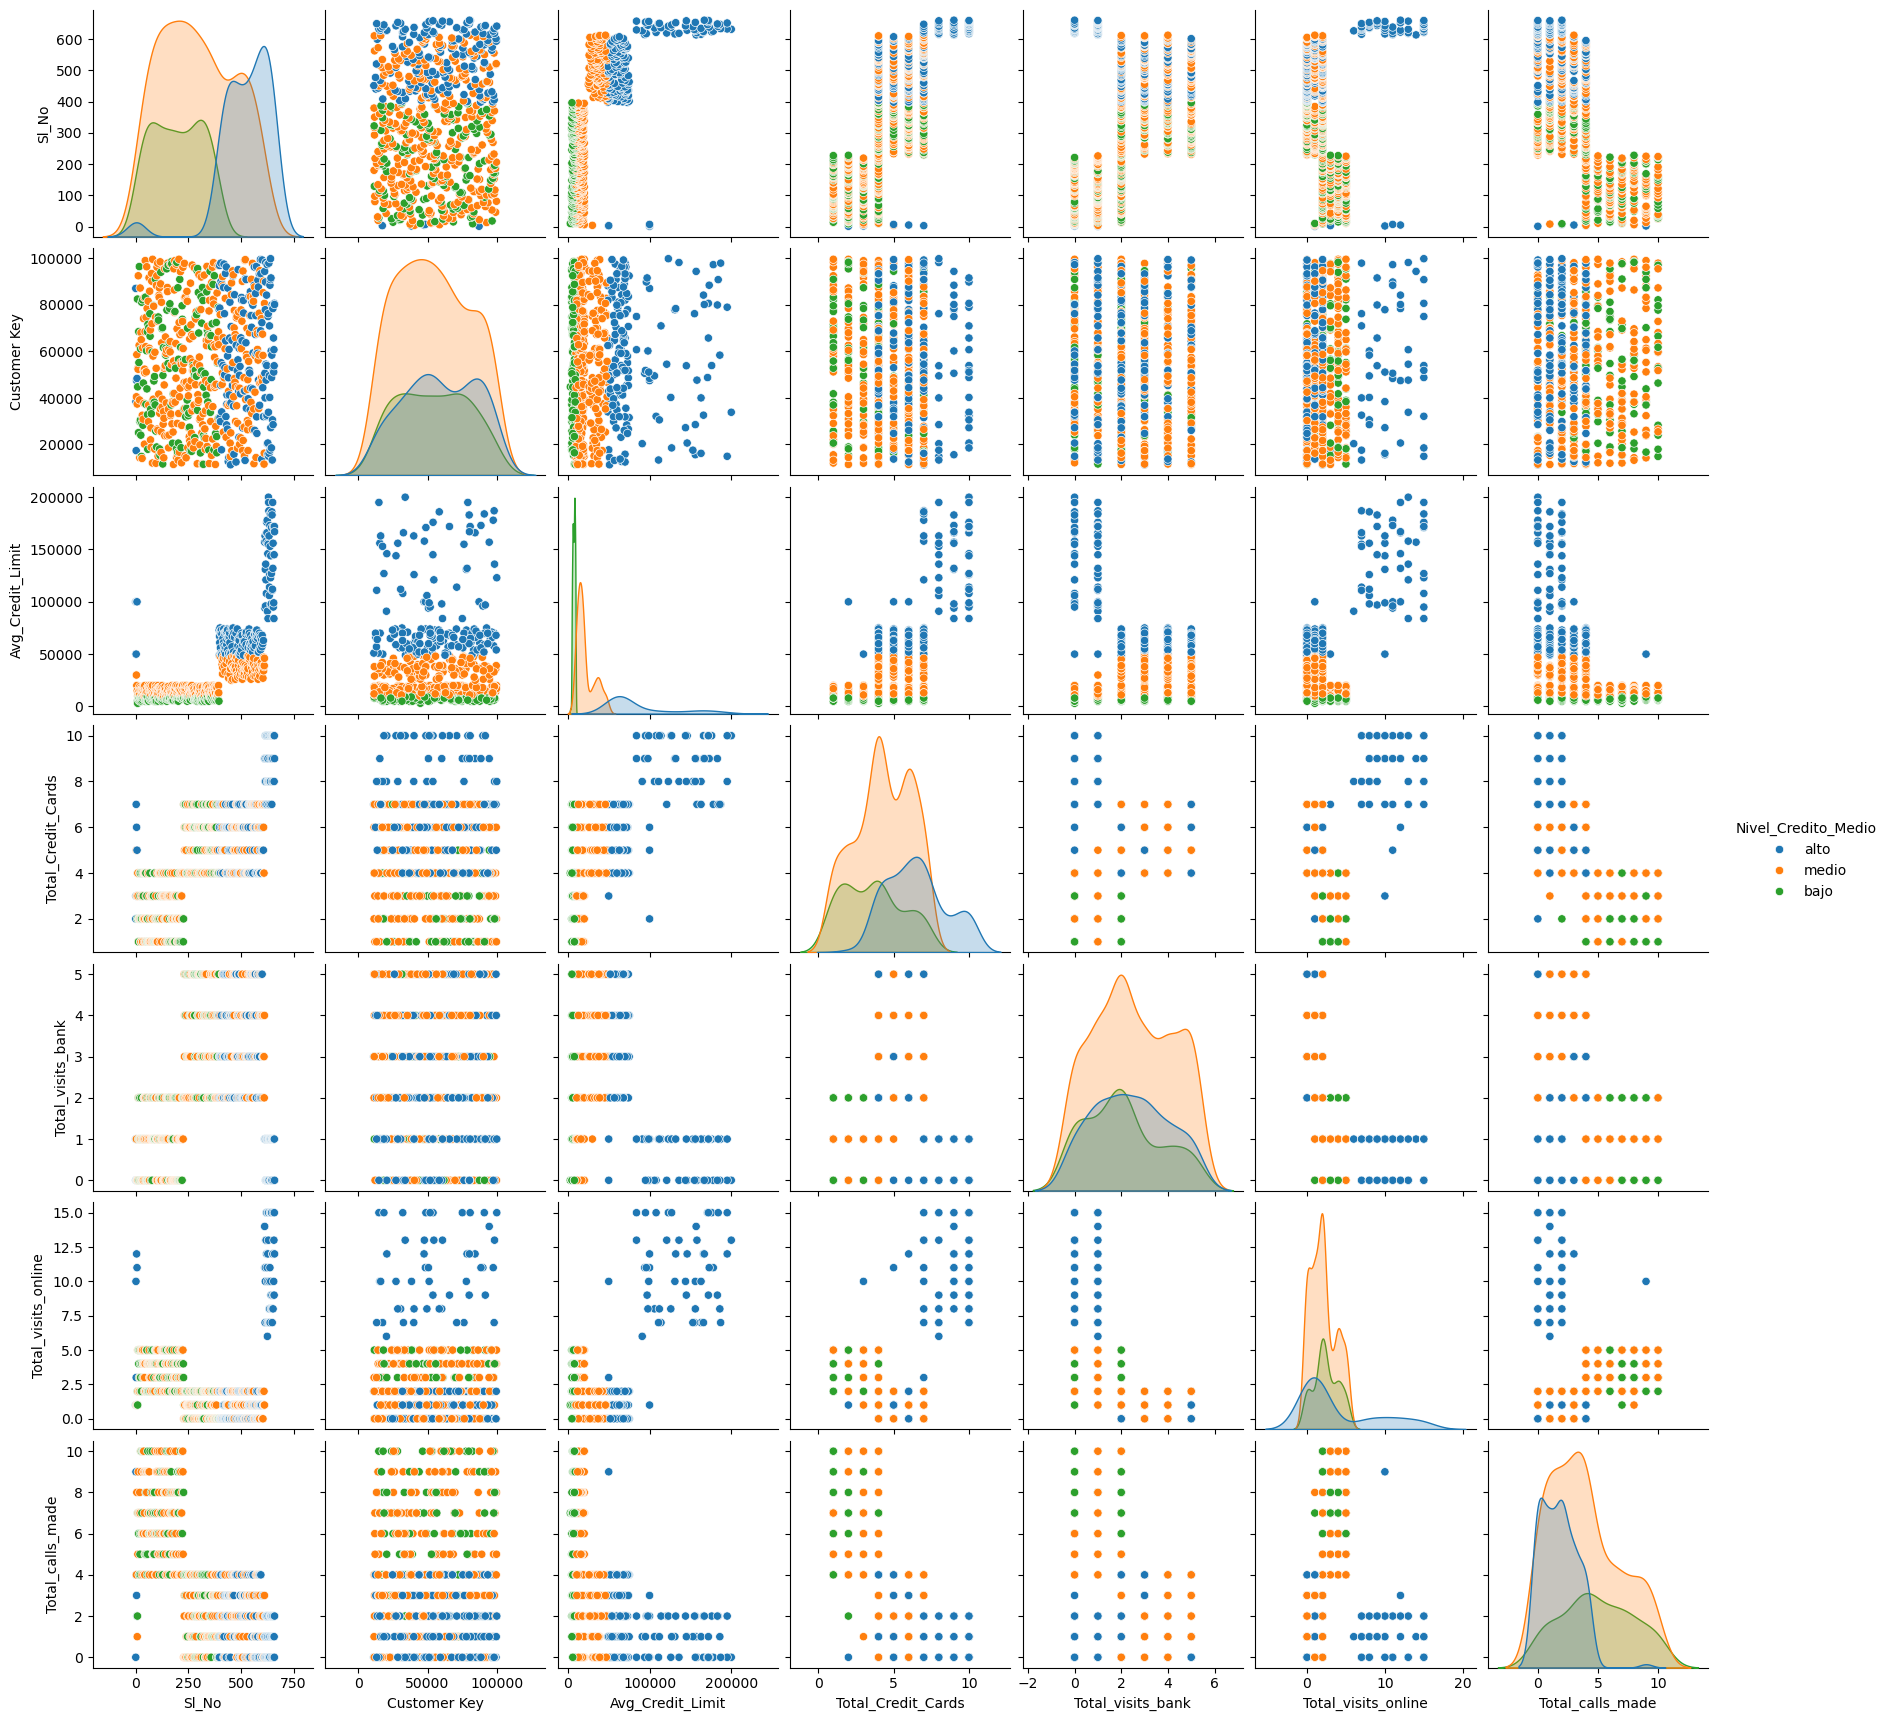

In [ ]:
sns.pairplot(data=customer, hue="Nivel_Credito_Medio") #Este gráfico nos sale mejor que el anterior de scatter plot
plt.show()

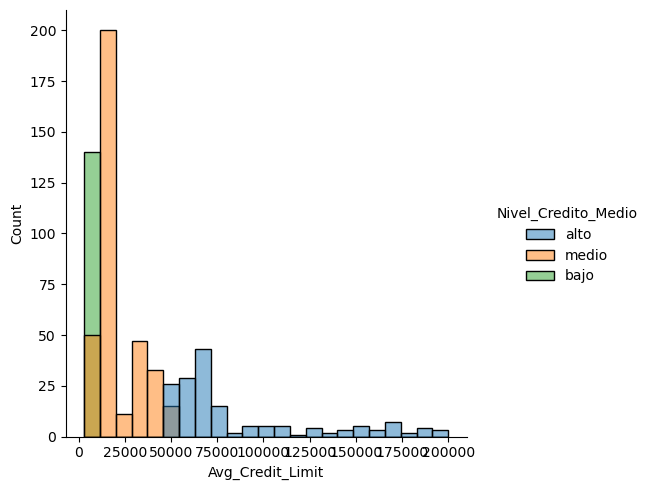

In [ ]:
sns.displot(customer, x="Avg_Credit_Limit", hue="Nivel_Credito_Medio")
plt.show()

In [ ]:
# CON LA FUNCIÓN GROUPBY Y COUNT CONTAMOS CUÁNTOS CLIENTES TENEMOS EN CADA CATEGORÍA; POR EJEMPLO VEMOS QUE
# LA POBLACIÓN DE ALTO ES MAYOR QUE LA DE BAJO
customer.groupby(['Nivel_Credito_Medio']).count()['Avg_Credit_Limit']

Nivel_Credito_Medio
alto     164
bajo     140
medio    356
Name: Avg_Credit_Limit, dtype: int64

/var/folders/nn/z9v_vhr52hn7q6gp663j8pdr0000gn/T/ipykernel_57685/2264610447.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = customer.corr()


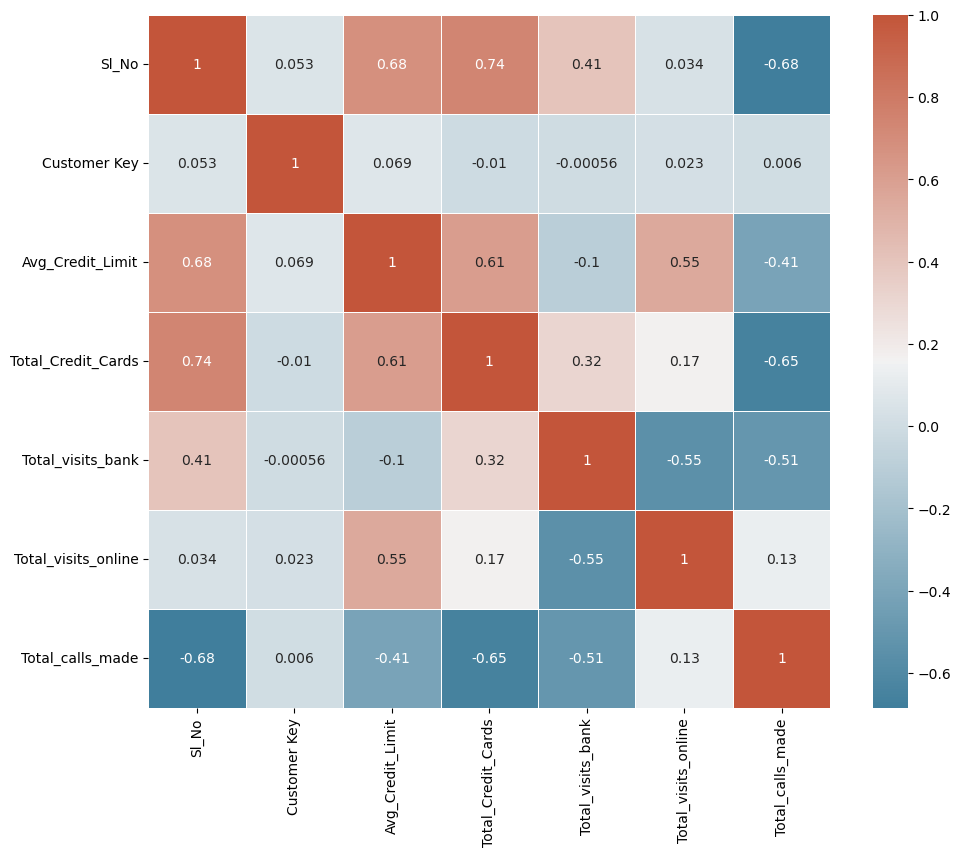

In [ ]:
#Veamos ahora un gráfico de correlaciones. INSPIRADO EN EL TUTORIAL DE LA GUÍA DE SEABORN https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# Compute the correlation matrix
corr = customer.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, cmap=cmap, linewidths=.5)
plt.show()

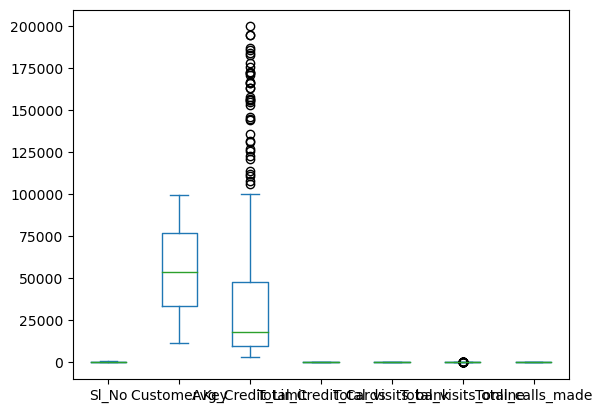

In [ ]:
customer.plot.box()
plt.show()

CON LA FUNCIÓN DESCRIBE() PUDIMOS VER QUE  Avg_Credit_Limit ES LA VARIABLE CON MAYOR OUTLIERS. VAMOS A DESCARTARLA POR UN MOMENTO PARA VER MÁS OUTLIERS.

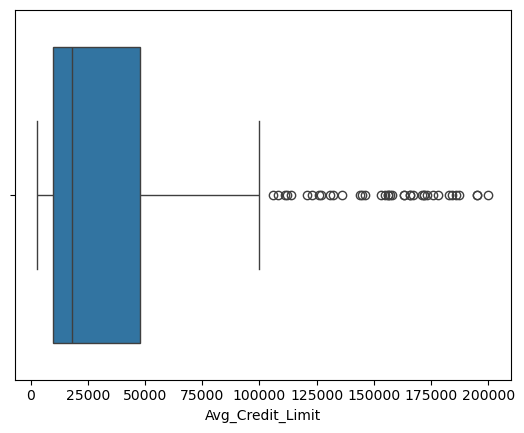

In [16]:
sns.boxplot(x = customer['Avg_Credit_Limit'])
plt.show()

In [17]:
customer_outliers= customer.drop(['Avg_Credit_Limit','Customer Key','Sl_No'],axis=1)
customer_outliers.head()

,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Nivel_Credito_Medio
0,2,1,1,0,alto
1,3,0,10,9,alto
2,7,1,3,4,alto
3,5,1,1,4,medio
4,6,0,12,3,alto


In [18]:
type(customer_outliers)

pandas.core.frame.DataFrame

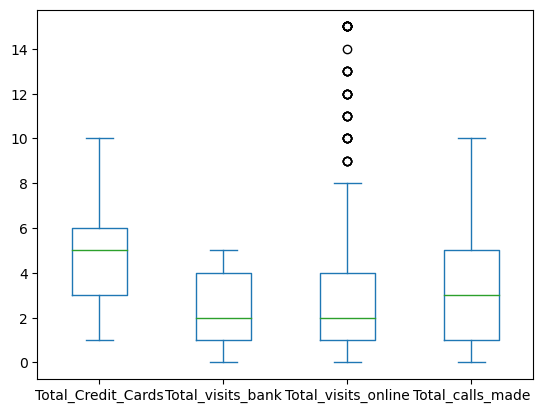

In [19]:
customer_outliers.plot.box()
plt.show()

PODEMOS VER ENTONCES QUE LA VARIABLE Total_visits_online PRESENTA OUTLIERS, ADEMÁS DE 'Avg_Credit_Limit'

VAMOS A TRATAR DE PROCESAR ESTOS OUTLIERS PARA QUE NO INTERFIERAN EN NUESTROS MODELOS DE CLUSTERING YA QUE ESTOS PUEDEN SER SENSIBLES

Vamos a fijar un límite para que los valores que se consideren outliers tomen ese límite y estén dentro de un rango no anómalo y justo.

In [59]:
# Por ejemplo consideremos los diagramas de cajas ya vistos; con ayuda del IQR (rango intercuartílico) podemos definir
# estos límites. Dado que sólo tenemos outliers por encima de Q3 + 1.5*IQR, entonces:
IQR = Q3-Q1
limite_bajo  = Q1 - 1.5 * IQR
limite_alto = Q3 + 1.5 * IQR

outliers = customer[(customer['Avg_Credit_Limit'] > limite_alto) | (customer['Avg_Credit_Limit'] < limite_bajo)]

In [61]:
outliers.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Nivel_Credito_Medio
612,613,94391,157000,9,1,14,1,alto
614,615,40019,163000,8,1,7,1,alto
615,616,77910,131000,9,1,10,1,alto
617,618,98216,136000,8,0,13,0,alto
618,619,54495,121000,7,0,13,2,alto


In [62]:
outliers.groupby('Nivel_Credito_Medio').count()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Nivel_Credito_Medio,,,,,,,
alto,39,39,39,39,39,39,39


Podemos ver que tenemos 39 valores atípicos en la variable llamada Avg_Credit_Limit. Vamos a controlarlos asignando el valor límite_alto. Ya que no tenemos ningún valor por debajo del límite bajo.

In [63]:
customer['Avg_Credit_Limit'] = np.where((customer['Avg_Credit_Limit'] > limite_alto), limite_alto, customer['Avg_Credit_Limit'])

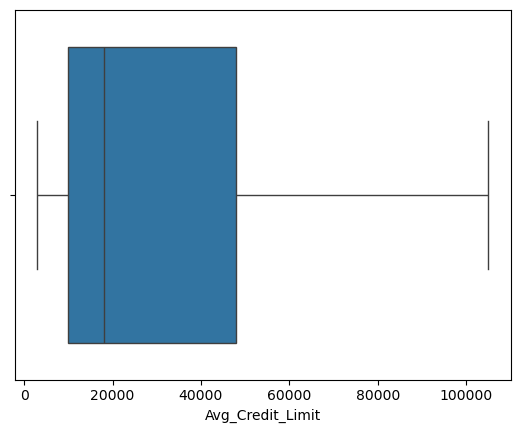

In [64]:
sns.boxplot(x = customer['Avg_Credit_Limit'])
plt.show()

Como vemos, acabamos de arreglar el problema de outliers para la variable de Avg_Credit_Limit. Trabajemos ahora con la otra variable que presentaba outliers, Total_visits_online

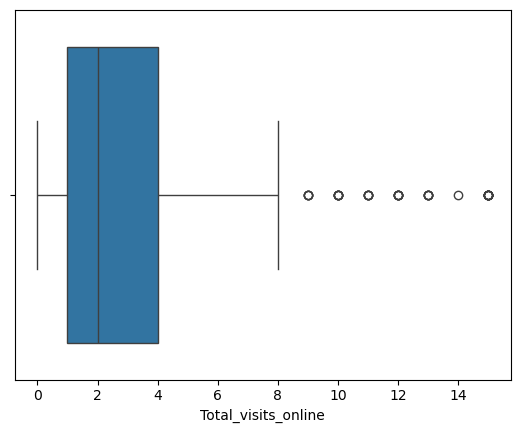

In [65]:
sns.boxplot(x = customer['Total_visits_online'])
plt.show()

In [67]:
#Definimos los percentiles

Q12 = customer["Total_visits_online"].quantile(0.25)
Q22 = customer["Total_visits_online"].quantile(0.50)
Q32 = customer["Total_visits_online"].quantile(0.75)

IQR2 = Q32-Q12
limite_bajo2  = Q12 - 1.5 * IQR2
limite_alto2 = Q32 + 1.5 * IQR2

outliers2 = customer[(customer['Total_visits_online'] > limite_alto2) | (customer['Total_visits_online'] < limite_bajo2)]

In [68]:
outliers2.groupby('Nivel_Credito_Medio').count()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Nivel_Credito_Medio,,,,,,,
alto,37,37,37,37,37,37,37


Tenemos 37 valores atípicos en la variable Total_visits_online, que todos pertenecen al nivel alto de Crédito Medio definida en la variable Avg_Credit_Limit. Ajustemos los outliers.

In [69]:
customer['Total_visits_online'] = np.where((customer['Total_visits_online'] > limite_alto2), limite_alto2, customer['Total_visits_online'])

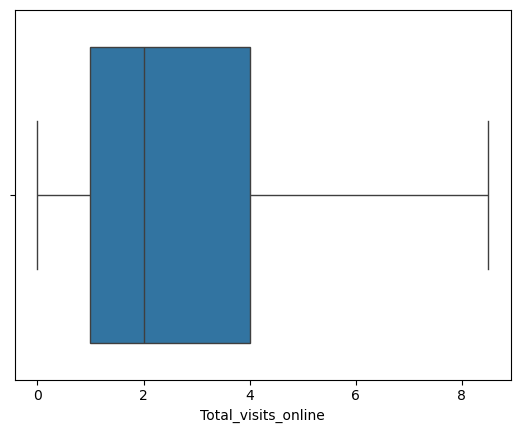

In [70]:
sns.boxplot(x = customer['Total_visits_online'])
plt.show()

In [73]:
# ACABAMOS DE CORREGIR NUESTROS DATOS PARA QUE NO TENGAN OUTLIERS QUE INTERFIERAN EN NUESTROS MODELOS.

customer.describe()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,330.500000,55141.443939,31666.666667,4.706061,2.403030,2.397727,3.583333
std,190.669872,25627.772200,28506.386332,2.167835,1.631813,2.256956,2.865317
min,1.000000,11265.000000,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,165.750000,33825.250000,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,330.500000,53874.500000,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,495.250000,77202.500000,48000.000000,6.000000,4.000000,4.000000,5.000000
max,660.000000,99843.000000,105000.000000,10.000000,5.000000,8.500000,10.000000


In [74]:
customer.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Nivel_Credito_Medio
0,1,87073,100000.0,2,1,1.0,0,alto
1,2,38414,50000.0,3,0,8.5,9,alto
2,3,17341,50000.0,7,1,3.0,4,alto
3,4,40496,30000.0,5,1,1.0,4,medio
4,5,47437,100000.0,6,0,8.5,3,alto


In [72]:
customer.groupby(['Nivel_Credito_Medio']).count()['Avg_Credit_Limit']

Nivel_Credito_Medio
alto     164
bajo     140
medio    356
Name: Avg_Credit_Limit, dtype: int64

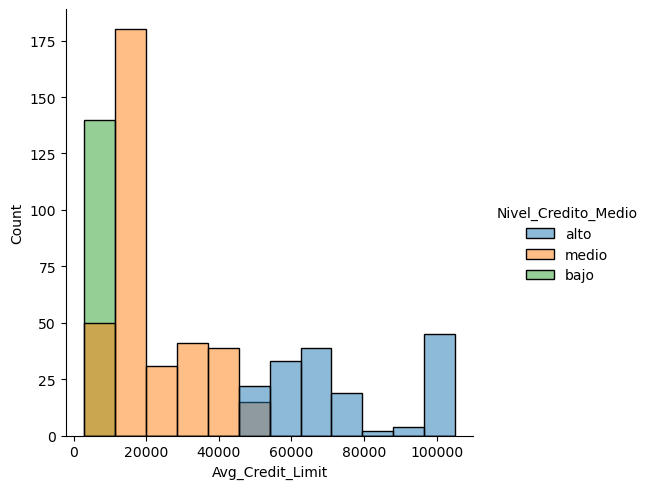

In [80]:
sns.displot(customer, x="Avg_Credit_Limit", hue="Nivel_Credito_Medio")
plt.show()

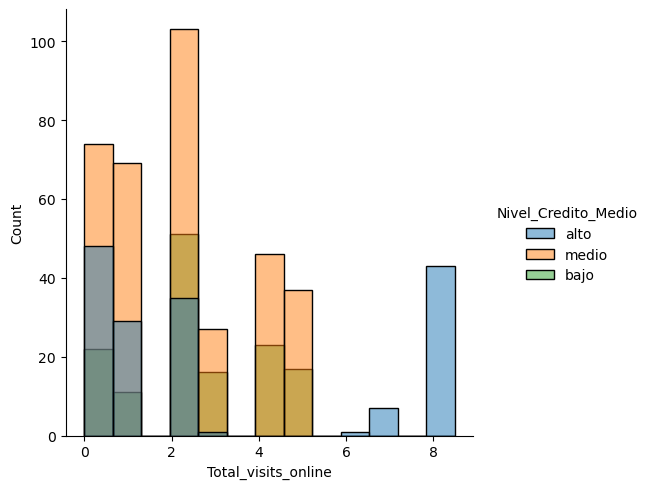

In [81]:
sns.displot(customer, x="Total_visits_online", hue="Nivel_Credito_Medio")
plt.show()

Estas serían las nuevas distribuciones para Avg_Credit_Limit y Total_visits_online

Una vez corregidos y analizados nuestros datos, podemos pasar al preprocesamiento de escalado para prepararlos para los modelos Clustering. Aplicaremos StandardScaler que ofrece Spark.

In [75]:
#Eliminamos las columnas que no necesitamos

customer_practico = customer.drop(['Sl_No','Customer Key','Nivel_Credito_Medio'],axis=1)
customer_practico.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000.0,2,1,1.0,0
1,50000.0,3,0,8.5,9
2,50000.0,7,1,3.0,4
3,30000.0,5,1,1.0,4
4,100000.0,6,0,8.5,3


In [76]:
customer_practico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Avg_Credit_Limit     660 non-null    float64
 1   Total_Credit_Cards   660 non-null    int64  
 2   Total_visits_bank    660 non-null    int64  
 3   Total_visits_online  660 non-null    float64
 4   Total_calls_made     660 non-null    int64  
dtypes: float64(2), int64(3)
memory usage: 25.9 KB


Es hora de convertir nuestro Dataframe de pandas a Spark.

In [101]:
# Convertir el DataFrame de pandas a DataFrame de Spark
customer_spark = spark.createDataFrame(customer_practico)

# Mostrar el DataFrame de Spark
customer_spark.show()

+----------------+------------------+-----------------+-------------------+----------------+
|Avg_Credit_Limit|Total_Credit_Cards|Total_visits_bank|Total_visits_online|Total_calls_made|
+----------------+------------------+-----------------+-------------------+----------------+
|        100000.0|                 2|                1|                1.0|               0|
|         50000.0|                 3|                0|                8.5|               9|
|         50000.0|                 7|                1|                3.0|               4|
|         30000.0|                 5|                1|                1.0|               4|
|        100000.0|                 6|                0|                8.5|               3|
|         20000.0|                 3|                0|                1.0|               8|
|        100000.0|                 5|                0|                8.5|               2|
|         15000.0|                 3|                0|               

A PARTIR DE AHORA TRABAJAMOS CON SPARK

In [102]:
# Para aplicar un modelo de Spark debemos vectorizar nuestros datos para cada punto.

from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=customer_spark.columns,outputCol="features")
customer_spark = assembler.transform(customer_spark)
customer_spark.show()

+----------------+------------------+-----------------+-------------------+----------------+--------------------+
|Avg_Credit_Limit|Total_Credit_Cards|Total_visits_bank|Total_visits_online|Total_calls_made|            features|
+----------------+------------------+-----------------+-------------------+----------------+--------------------+
|        100000.0|                 2|                1|                1.0|               0|[100000.0,2.0,1.0...|
|         50000.0|                 3|                0|                8.5|               9|[50000.0,3.0,0.0,...|
|         50000.0|                 7|                1|                3.0|               4|[50000.0,7.0,1.0,...|
|         30000.0|                 5|                1|                1.0|               4|[30000.0,5.0,1.0,...|
|        100000.0|                 6|                0|                8.5|               3|[100000.0,6.0,0.0...|
|         20000.0|                 3|                0|                1.0|             

APLICAMOS EL MÉTODO STANDARD SCALER PARA CONVERTIR NUESTROS DATOS A UNA DISTRIBUCIÓN NORMAL

In [342]:
# Aplicamos el método StandardScaler para escalar nuestros datos y dejarlos con media nula y varianza la unidad.
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=True)  #Marcamos withMean=True para que nos escale los datos con media nula.

scalerModel = scaler.fit(customer_spark)
customer_spark_scaled = scalerModel.transform(customer_spark)
customer_spark_scaled.show()

+----------------+------------------+-----------------+-------------------+----------------+--------------------+--------------------+
|Avg_Credit_Limit|Total_Credit_Cards|Total_visits_bank|Total_visits_online|Total_calls_made|            features|      scaledFeatures|
+----------------+------------------+-----------------+-------------------+----------------+--------------------+--------------------+
|        100000.0|                 2|                1|                1.0|               0|[100000.0,2.0,1.0...|[2.39712366686785...|
|         50000.0|                 3|                0|                8.5|               9|[50000.0,3.0,0.0,...|[0.64313073989137...|
|         50000.0|                 7|                1|                3.0|               4|[50000.0,7.0,1.0,...|[0.64313073989137...|
|         30000.0|                 5|                1|                1.0|               4|[30000.0,5.0,1.0,...|[-0.0584664308992...|
|        100000.0|                 6|                0|

In [112]:
from pyspark.ml.stat import Summarizer  #Vamos a verificar que efectivamente tenemos nuestros datos bien escalados.

# create summarizer for multiple metrics "mean" and "count"
summarizer = Summarizer.metrics("mean", "variance")

# compute statistics for single metric "mean" and "variance"
customer_spark_scaled.select(Summarizer.mean(customer_spark_scaled.scaledFeatures), 
                             Summarizer.variance(customer_spark_scaled.scaledFeatures)).show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------+
|mean(scaledFeatures)                                                                                             |variance(scaledFeatures)                                                                        |
+-----------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------+
|[2.7842311789427754E-16,-2.37700484295722E-15,-7.8236028766554E-16,1.1275702593849246E-17,-1.122149248522497E-15]|[1.0000000000000004,1.0000000000000002,0.9999999999999997,1.0000000000000004,0.9999999999999974]|
+-----------------------------------------------------------------------------------------------------------------+---------------------------------

HECHO EL ESCALADO, YA PODRÍAMOS APLICAR UN MODELO CLUSTERING. APLIQUEMOS EL K-MEDIAS. VEAMOS CUÁNTOS CLÚSTERES DEBERÍA NUESTRO MODELOS RENDIR:

In [134]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# MÉTODO DE ELBOW CON PYSPARK
cost =[]

for i in range(2,15):
    kmeans = KMeans(featuresCol='scaledFeatures',k=i)
    kmeansmodel = kmeans.fit(customer_spark_scaled)
    summary = kmeansmodel.summary
    cost.append(summary.trainingCost)

In [135]:
cost # Obtenemos grandes medidas de Variación intra-cluster debido al número de columnas que participan en el clustering

[1946.9502838490423,
 996.953278740781,
 812.6231796719296,
 734.1000323803326,
 639.4159485019923,
 588.1660776541956,
 565.5325268831508,
 597.9714561046723,
 525.0435406793417,
 498.4017173398071,
 472.55680319143977,
 462.67239293831983,
 445.1122543553669]

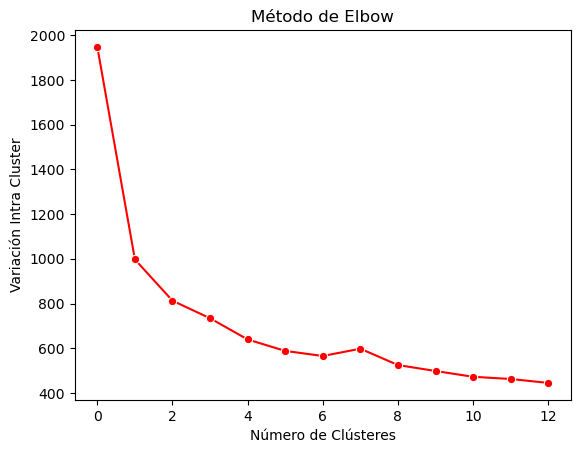

In [271]:
sns.lineplot(cost,marker='o',color='red')
plt.title('Método de Elbow')
plt.xlabel('Número de Clústeres')
plt.ylabel('Variación Intra Cluster')
plt.show()

AUNQUE EL MÉTODO DE ELBOW NO ES DETERMINISTA, PODEMOS INTUIR QUE 3 CLÚSTERES PUEDEN SER SUFICIENTES PARA RESOLVER EL PROBLEMA DE CLUSTERING. ENTONCES:

In [265]:
sil_evaluador=[]
for i in range(2,15):
    kmeans = KMeans(featuresCol='scaledFeatures',k=i)
    kmeansmodel = kmeans.fit(customer_spark_scaled)
    evaluator = ClusteringEvaluator(featuresCol='scaledFeatures', predictionCol='prediction')
    silhouette = evaluator.evaluate(kmeansmodel.transform(customer_spark_scaled))
    sil_evaluador.append(silhouette)

In [266]:
sil_evaluador

[0.5777404900234684,
 0.7369876275064005,
 0.5610530354458858,
 0.43532712884151425,
 0.4211404287621281,
 0.41489523015581026,
 0.39673161771294757,
 0.4580193940179078,
 0.3742406350931612,
 0.3642994842300489,
 0.3654684734247248,
 0.33078926600309416,
 0.3606809103752657]

In [273]:
len(sil_evaluador)

13

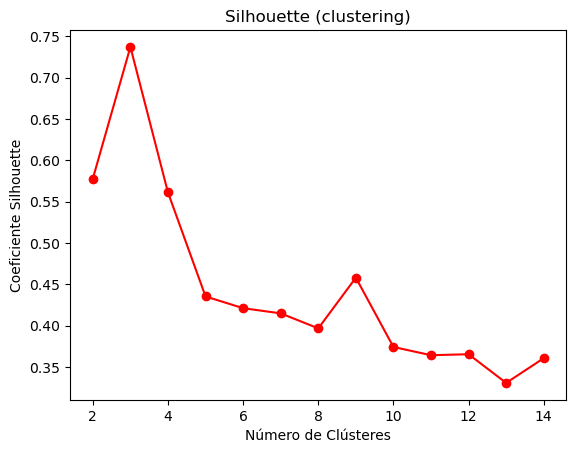

In [275]:
num_clusters = list(range(2, 15))
plt.plot(num_clusters, sil_evaluador, marker='o', color='red')

plt.title('Silhouette (clustering)')
plt.xlabel('Número de Clústeres')
plt.ylabel('Coeficiente Silhouette')
plt.show()

CURIOSAMENTE, SEGÚN EL VALOR SILHOUETTE, OBTENEMOS MAYOR RENDIMIENTO CON 2 CLÚSTERES. DE TODOS MODOS, VAMOS A SER FIELES A NUESTRA IDEA INICIAL DE 3 CLÚSTERES; TAMBIÉN PORQUE ASÍ LO SUGIERE EL DIAGRAMA DE CAJAS Y LA NUEVA VARIABLE Credito_Medio QUE HICIMOS

In [264]:
# Trains a k-means model.
kmeans = KMeans(featuresCol='scaledFeatures',k=3)
kmeansmodel = kmeans.fit(customer_spark_scaled)

# Make predictions
kmeanspredictions = kmeansmodel.transform(customer_spark_scaled)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(featuresCol='scaledFeatures', predictionCol='prediction')

silhouette = evaluator.evaluate(kmeanspredictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.7369876275064005


In [157]:
kmeanspredictions.show(truncate=False)

+----------------+------------------+-----------------+-------------------+----------------+--------------------------+-----------------------------------------------------------------------------------------------------+----------+
|Avg_Credit_Limit|Total_Credit_Cards|Total_visits_bank|Total_visits_online|Total_calls_made|features                  |scaledFeatures                                                                                       |prediction|
+----------------+------------------+-----------------+-------------------+----------------+--------------------------+-----------------------------------------------------------------------------------------------------+----------+
|100000.0        |2                 |1                |1.0                |0               |[100000.0,2.0,1.0,1.0,0.0]|[2.397123666867853,-1.2482780199737058,-0.8597985246008519,-0.6192976035306689,-1.2505888742545208]  |0         |
|50000.0         |3                 |0                |8.5          

In [158]:
kmeanspredictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   50|
|         2|  224|
|         0|  386|
+----------+-----+



Ahora, para ver como han quedado nuestros datos gráficamente, VAMOS A UTILIZAR PCA PARA VISUALIZARLOS. DOS COMPONENTES PRINCIPALES.

In [161]:
from pyspark.ml.feature import PCA

pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
pcamodel = pca.fit(customer_spark_scaled)
customer_pca_spark = pcamodel.transform(customer_spark_scaled).select('pcaFeatures')

In [162]:
customer_pca_spark.show(truncate=False)

+-----------------------------------------+
|pcaFeatures                              |
+-----------------------------------------+
|[-0.7341660838269763,0.8986051399540523] |
|[2.3787814650682737,2.692662673419947]   |
|[-0.3396694603751786,1.1843807733309495] |
|[0.2827512382120267,0.00948478537336368] |
|[-0.2852265225563084,3.882247740168497]  |
|[1.994334188038595,-0.06798878644311804] |
|[-0.23527258568068543,3.7618948812794506]|
|[0.6432572911233393,-0.2122992437751765] |
|[1.3159050700801926,-0.20163524525189527]|
|[1.7727839938799108,-0.26869904938669065]|
|[1.5878775339906346,1.0222028980506863]  |
|[1.967175572670473,0.09360216563019089]  |
|[2.6301214229794234,0.14104409660744238] |
|[2.3060095853566804,0.3780276922569129]  |
|[1.7583364694395265,-0.1547413551582886] |
|[2.5267144337077,0.7766733893147872]     |
|[1.3270062113365433,-0.30263163594878034]|
|[1.7595829497115316,0.1630024579965316]  |
|[1.7337408008592359,-0.6474402373687582] |
|[1.815596161063436,0.9110151424

In [170]:
column_names=['Primera_componente','Segunda_Componente']
##ESTO ES PARA CONVERTIR EL VECTOR DENSE (DONDE SE HA ALMACENADO LAS COMPONENTES DE SPARK EN UN DATAFRAME)
customer_pca = customer_pca_spark.rdd.map(lambda x:[float(y) for y in x['pcaFeatures']]).toDF(column_names)

In [171]:
customer_pca.show(truncate=False)

+--------------------+--------------------+
|Primera_componente  |Segunda_Componente  |
+--------------------+--------------------+
|-0.7341660838269763 |0.8986051399540523  |
|2.3787814650682737  |2.692662673419947   |
|-0.3396694603751786 |1.1843807733309495  |
|0.2827512382120267  |0.00948478537336368 |
|-0.2852265225563084 |3.882247740168497   |
|1.994334188038595   |-0.06798878644311804|
|-0.23527258568068543|3.7618948812794506  |
|0.6432572911233393  |-0.2122992437751765 |
|1.3159050700801926  |-0.20163524525189527|
|1.7727839938799108  |-0.26869904938669065|
|1.5878775339906346  |1.0222028980506863  |
|1.967175572670473   |0.09360216563019089 |
|2.6301214229794234  |0.14104409660744238 |
|2.3060095853566804  |0.3780276922569129  |
|1.7583364694395265  |-0.1547413551582886 |
|2.5267144337077     |0.7766733893147872  |
|1.3270062113365433  |-0.30263163594878034|
|1.7595829497115316  |0.1630024579965316  |
|1.7337408008592359  |-0.6474402373687582 |
|1.815596161063436   |0.91101514

In [172]:
customer_pca = customer_pca.toPandas()

In [173]:
#Añadimos nuestras predicciones de kmeans al dataset customer que teníamos antes
customer_kmeanspredictions = kmeanspredictions.toPandas()
customer_kmeans = pd.concat([customer_pca, customer_kmeanspredictions[['prediction']]], axis=1)

In [174]:
customer_kmeans

,Primera_componente,Segunda_Componente,prediction
0,-0.734166,0.898605,0
1,2.378781,2.692663,2
2,-0.339669,1.184381,0
3,0.282751,0.009485,0
4,-0.285227,3.882248,1
...,...,...,...
655,-2.148089,3.994968,1
656,-1.535838,3.740965,1
657,-1.522263,3.885426,1
658,-2.230712,4.102793,1


In [301]:
customer_kmeans.groupby('prediction').count()

,Primera_componente,Segunda_Componente
prediction,,
0,386,386
1,50,50
2,224,224


VAMOS A GRAFICAR LO QUE NOS HA SALIDO

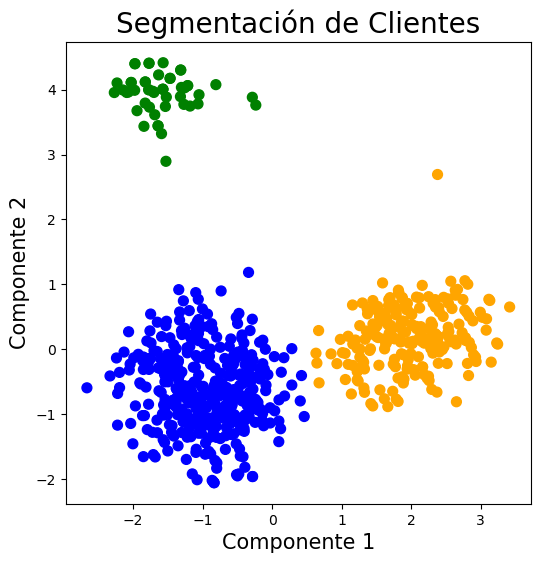

In [200]:
fig = plt.figure(figsize = (6,6))

ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Componente 1', fontsize = 15)
ax.set_ylabel('Componente 2', fontsize = 15)
ax.set_title('Segmentación de Clientes', fontsize= 20)

colores= np.array(['blue','green','orange'])
ax.scatter(x=customer_kmeans.Primera_componente, y=customer_kmeans.Segunda_Componente,
          c=colores[customer_kmeans.prediction], s=50)

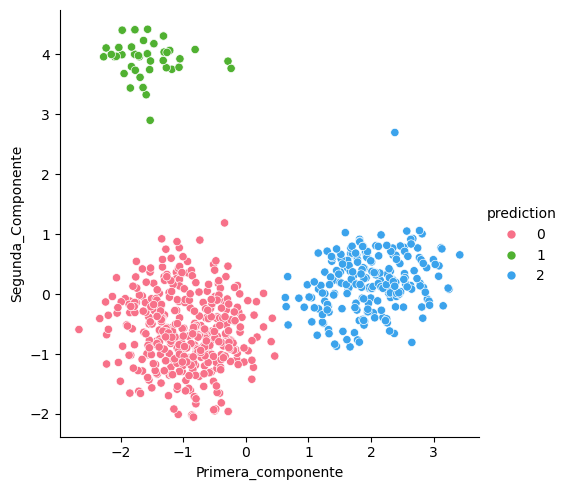

In [287]:
# Definir una paleta de colores para los 3 labels
palette = sns.color_palette("husl", 3)

# Crear el gráfico relacional con colores específicos para cada label
sns.relplot(data=customer_kmeans, x="Primera_componente", y="Segunda_Componente", hue="prediction", palette=palette)

plt.show()

PODEMOS VER QUE SÍ SE HICIERON BIEN LOS CLÚSTERES, YA QUE NO HAY PUNTOS ENTREMEZCLADOS NI NADA PARECIDO. LUEGO VAMOS A DAR POR VÁLIDO ESTA SOLUCIÓN DE K-MEANS QUE HEMOS OBTENIDO. AHORA DEBERÍAMOS INTERPRETAR LOS RESULTADOS.

In [176]:
# Vamos a hacer una pequeña prueba.

customer_pruebanivel = pd.concat([customer_kmeans, customer[['Nivel_Credito_Medio']]], axis=1)
customer_pruebanivel.head()

,Primera_componente,Segunda_Componente,prediction,Nivel_Credito_Medio
0,-0.734166,0.898605,0,alto
1,2.378781,2.692663,2,alto
2,-0.339669,1.184381,0,alto
3,0.282751,0.009485,0,medio
4,-0.285227,3.882248,1,alto


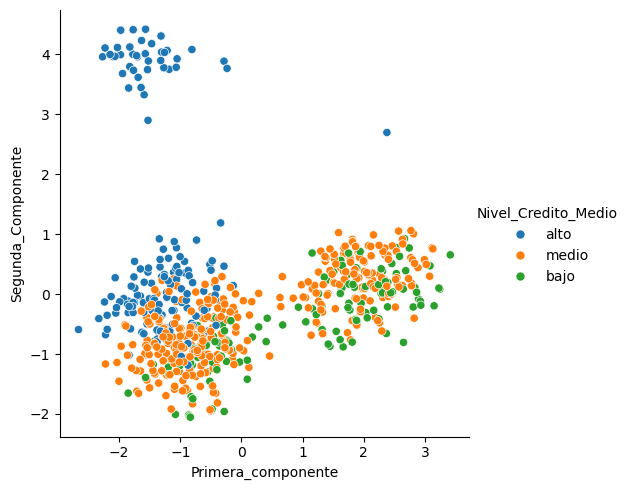

In [182]:
# Pequeña prueba para ver si de algún modo coincidía con la clasificación intuitiva que hicimos al principio.
# Es cierto que hay un grupo del nivel alto que está muy bien definido.

sns.relplot(customer_pruebanivel,
    x="Primera_componente", y="Segunda_Componente",
    hue="Nivel_Credito_Medio")

ESTA ÚLTIMA PRUEBA NO NOS HA DADO BUENOS RESULTADOS

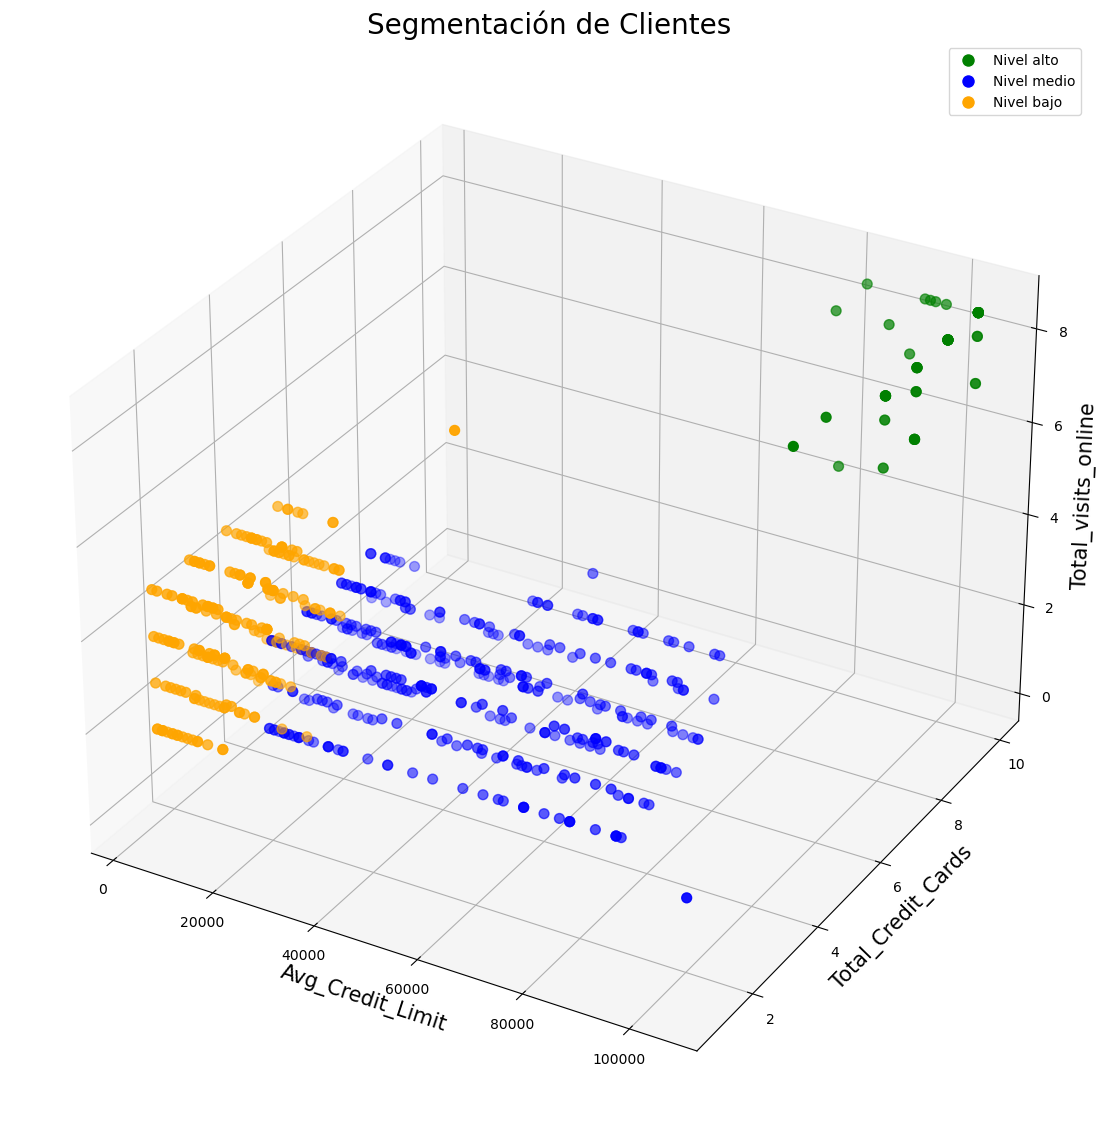

In [217]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('Avg_Credit_Limit', fontsize=15)
ax.set_ylabel('Total_Credit_Cards', fontsize=15)
ax.set_zlabel('Total_visits_online', fontsize=15)
ax.set_title('Segmentación de Clientes', fontsize=20)


legend_labels = {'Nivel alto': 'green', 'Nivel medio': 'blue', 'Nivel bajo': 'orange'}
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=legend_labels[label], markersize=10, label=label) for label in legend_labels]

ax.legend(handles=legend_elements, loc='upper right')

colores = np.array(['blue', 'green', 'orange'])
ax.scatter(customer.Avg_Credit_Limit, customer.Total_Credit_Cards, customer.Total_visits_online,
           c=colores[customer_kmeans.prediction], s=50)

plt.show()

EN ESTE GRÁFICO PODRÍAMOS INTERPRETAR CÓMO EL GRUPO VERDE PERTENECE A UNOS USUARIOS CON UN CRÉDITO LÍMITE ALTO, EL AZUL AL CRÉDITO MEDIO Y EL NARANJA AL CRÉDITO MÁS INFERIOR.

Podemos pasar a rendir ahora el modelo GMM.

In [221]:
#Este es el Dataframe de Spark con el que estábamos trabajando. Pasemos ahora a trabajar GMM.
customer_spark_scaled.show()

+----------------+------------------+-----------------+-------------------+----------------+--------------------+--------------------+
|Avg_Credit_Limit|Total_Credit_Cards|Total_visits_bank|Total_visits_online|Total_calls_made|            features|      scaledFeatures|
+----------------+------------------+-----------------+-------------------+----------------+--------------------+--------------------+
|        100000.0|                 2|                1|                1.0|               0|[100000.0,2.0,1.0...|[2.39712366686785...|
|         50000.0|                 3|                0|                8.5|               9|[50000.0,3.0,0.0,...|[0.64313073989137...|
|         50000.0|                 7|                1|                3.0|               4|[50000.0,7.0,1.0,...|[0.64313073989137...|
|         30000.0|                 5|                1|                1.0|               4|[30000.0,5.0,1.0,...|[-0.0584664308992...|
|        100000.0|                 6|                0|

In [235]:
from pyspark.ml.clustering import GaussianMixture

gmm = GaussianMixture(k=3,featuresCol='scaledFeatures', predictionCol='predictionGMM')
gmmmodel = gmm.fit(customer_spark_scaled)

print("Gaussians shown as a DataFrame: ")
gmmmodel.gaussiansDF.show(truncate=False)

Gaussians shown as a DataFrame: 
+--------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|mean                                                                                              |cov                                                                                                                                                                                                                                                                         |
+--------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------

In [231]:
gmm.getPredictionCol()

'predictionGMM'

In [232]:
gmm.getProbabilityCol()

'probability'

In [237]:
gaussians = gmmmodel.gaussians
gaussians[0].mean

DenseVector([2.4902, 1.8604, -1.105, 2.562, -0.8732])

In [239]:
gaussians[0].cov

DenseMatrix(5, 5, [0.0326, -0.0107, -0.0084, 0.0003, -0.0039, -0.0107, 0.3399, 0.0386, ..., -0.0103, 0.0722, 0.0102, -0.0039, -0.0139, -0.0019, 0.0102, 0.0929], 0)

In [240]:
gaussians[1].mean

DenseVector([-0.6844, -1.0555, -0.897, 0.5066, 1.1436])

In [241]:
gaussians[1].cov

DenseMatrix(5, 5, [0.0336, 0.0077, -0.0099, 0.0227, 0.0045, 0.0077, 0.2595, 0.0096, ..., -0.0047, 0.2766, 0.0415, 0.0045, -0.0172, -0.0223, 0.0415, 0.4831], 0)

In [242]:
gaussians[2].mean

DenseVector([0.0758, 0.3739, 0.6664, -0.6278, -0.5534])

In [243]:
gaussians[2].cov

DenseMatrix(5, 5, [0.6028, 0.0005, -0.0739, -0.0184, 0.0042, 0.0005, 0.2764, -0.0049, ..., 0.0075, 0.1439, -0.0035, 0.0042, 0.0196, -0.0105, -0.0035, 0.2487], 0)

In [246]:
gmmmodel.predict(customer_spark_scaled.head().scaledFeatures)

2

In [249]:
gmmmodel.getMaxIter()

100

In [278]:
predictionsgmm = gmmmodel.transform(customer_spark_scaled).select("scaledFeatures", "predictionGMM")
rows = predictionsgmm.collect()

In [279]:
rows

[Row(scaledFeatures=DenseVector([2.3971, -1.2483, -0.8598, -0.6193, -1.2506]), predictionGMM=2),
 Row(scaledFeatures=DenseVector([0.6431, -0.787, -1.4726, 2.7038, 1.8904]), predictionGMM=1),
 Row(scaledFeatures=DenseVector([0.6431, 1.0582, -0.8598, 0.2669, 0.1454]), predictionGMM=2),
 Row(scaledFeatures=DenseVector([-0.0585, 0.1356, -0.8598, -0.6193, 0.1454]), predictionGMM=2),
 Row(scaledFeatures=DenseVector([2.3971, 0.5969, -1.4726, 2.7038, -0.2036]), predictionGMM=0),
 Row(scaledFeatures=DenseVector([-0.4093, -0.787, -1.4726, -0.6193, 1.5414]), predictionGMM=1),
 Row(scaledFeatures=DenseVector([2.3971, 0.1356, -1.4726, 2.7038, -0.5526]), predictionGMM=0),
 Row(scaledFeatures=DenseVector([-0.5847, -0.787, -1.4726, -0.6193, -0.9016]), predictionGMM=1),
 Row(scaledFeatures=DenseVector([-0.9355, -1.2483, -1.4726, -0.1762, -0.5526]), predictionGMM=1),
 Row(scaledFeatures=DenseVector([-1.0056, -0.3257, -1.4726, -0.6193, 1.1924]), predictionGMM=1),
 Row(scaledFeatures=DenseVector([-0.7601,

In [280]:
#En una de las columnas se mostrarán las predicciones hechas por el modelo GMM

predictionsgmm.show()

+--------------------+-------------+
|      scaledFeatures|predictionGMM|
+--------------------+-------------+
|[2.39712366686785...|            2|
|[0.64313073989137...|            1|
|[0.64313073989137...|            2|
|[-0.0584664308992...|            2|
|[2.39712366686785...|            0|
|[-0.4092650162945...|            1|
|[2.39712366686785...|            0|
|[-0.5846643089921...|            1|
|[-0.9354628943874...|            1|
|[-1.0056226114665...|            1|
|[-0.7600636016898...|            1|
|[-0.6548240260712...|            1|
|[-0.7249837431502...|            1|
|[-0.7951434602293...|            1|
|[-0.9003830358479...|            1|
|[-0.8302233187688...|            1|
|[-0.5846643089921...|            1|
|[-0.8302233187688...|            1|
|[-0.7249837431502...|            1|
|[-0.4443448748340...|            1|
+--------------------+-------------+
only showing top 20 rows



In [281]:
# Evaluate clustering by computing Silhouette score
evaluatorgmm = ClusteringEvaluator(featuresCol='scaledFeatures', predictionCol='predictionGMM')

silhouette = evaluatorgmm.evaluate(predictionsgmm)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.7369876275064005


PODEMOS VER QUE TANTO GMM COMO KMEANS HAN RENDIDO EXACTAMENTE IGUAL (OBTENEMOS EL MISMO COEFICIENTE DE SILHOUETTE) ME PARECE QUE HAN CLASIFICADO EXACTAMENTE IGUAL LOS PUNTOS EN LOS CLÚSTERES.

In [283]:
#Igual que con el K-means, añadimos nuestras predicciones de kmeans al dataset customer que teníamos antes
customer_gmmpredictions = predictionsgmm.toPandas()
customer_gmm = pd.concat([customer_pca, customer_gmmpredictions[['predictionGMM']]], axis=1)

In [284]:
customer_gmm.head()

,Primera_componente,Segunda_Componente,predictionGMM
0,-0.734166,0.898605,2
1,2.378781,2.692663,1
2,-0.339669,1.184381,2
3,0.282751,0.009485,2
4,-0.285227,3.882248,0


In [299]:
customer_gmm.groupby('predictionGMM').count()

,Primera_componente,Segunda_Componente
predictionGMM,,
0,50,50
1,224,224
2,386,386


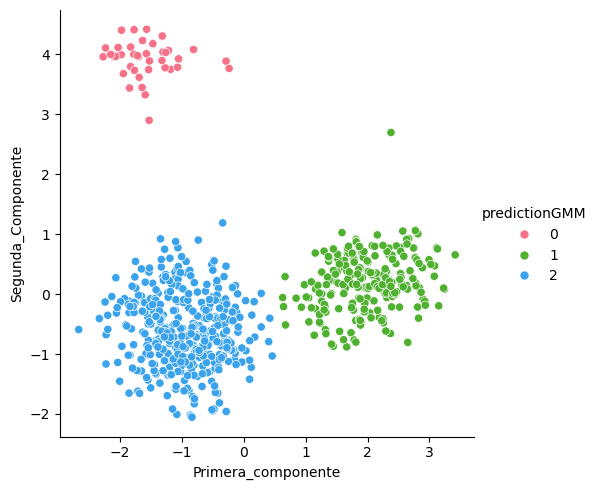

In [285]:
# Definir una paleta de colores para los 3 labels
palette = sns.color_palette("husl", 3)

# Crear el gráfico relacional con colores específicos para cada label
sns.relplot(data=customer_gmm, x="Primera_componente", y="Segunda_Componente", hue="predictionGMM", palette=palette)

plt.show()

LOS DOS MODELOS RINDEN IGUAL. PASEMOS ENTONCES A VER SI CON BISECTING K-MEANS EXISTE ALGUNA DIFERENCIA.

In [289]:
customer_spark_scaled.show()

+----------------+------------------+-----------------+-------------------+----------------+--------------------+--------------------+
|Avg_Credit_Limit|Total_Credit_Cards|Total_visits_bank|Total_visits_online|Total_calls_made|            features|      scaledFeatures|
+----------------+------------------+-----------------+-------------------+----------------+--------------------+--------------------+
|        100000.0|                 2|                1|                1.0|               0|[100000.0,2.0,1.0...|[2.39712366686785...|
|         50000.0|                 3|                0|                8.5|               9|[50000.0,3.0,0.0,...|[0.64313073989137...|
|         50000.0|                 7|                1|                3.0|               4|[50000.0,7.0,1.0,...|[0.64313073989137...|
|         30000.0|                 5|                1|                1.0|               4|[30000.0,5.0,1.0,...|[-0.0584664308992...|
|        100000.0|                 6|                0|

In [355]:
pip install --upgrade pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 10.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 6.6 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425347 sha256=9c983e61c05f0dd67826c1b1f49a10c6e458bd22d04332cee506acf5964bb061
  Stored in directory: /Users/rafaelotero/Library/Caches/pip/wheels/a6/ce/f9/17d82c92f044018df2fe30af63ac043447720d5b2cee39b40f
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.5
    Uninstalling py4j-0.10.9.5:
      Successfully uninstalled py4j-0.10.9.5
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.3.1
    Uninstalling pyspark-3.3.1:
      Successfully uninstalled pyspark-3.3.1
Note: you may need to restart the kernel to use updated packages.


In [366]:
from pyspark.ml.clustering import BisectingKMeans

# Trains a bisecting k-means model.
bkm = BisectingKMeans(k=3, featuresCol='scaledFeatures', predictionCol='predictionBikmeans')
bikmeansmodel = bkm.fit(customer_spark_scaled)

# Make predictions
predictionsbikmeans = bikmeansmodel.transform(customer_spark_scaled)

In [367]:
centers = bikmeansmodel.clusterCenters()

In [368]:
centers

[array([-1.52066911e-16, -4.82105938e-15, -2.15215051e-15,  1.34572488e-16,
        -2.25408917e-17])]

In [369]:
predictionsbikmeans.select('predictionBikmeans').distinct().show()

+------------------+
|predictionBikmeans|
+------------------+
|                 0|
+------------------+



In [370]:
# Evaluate clustering by computing Silhouette score. EN EL CASO DE BISECTING K MEANS NOS SALE SÓLO UN CLÚSTER.
evaluatorbikmeans = ClusteringEvaluator(featuresCol='scaledFeatures', predictionCol='predictionBikmeans')

silhouette = evaluatorbikmeans.evaluate(predictionsbikmeans)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Py4JJavaError: An error occurred while calling o9337.evaluate.
: java.lang.AssertionError: assertion failed: Number of clusters must be greater than one.
	at scala.Predef$.assert(Predef.scala:223)
	at org.apache.spark.ml.evaluation.SquaredEuclideanSilhouette$.computeSilhouetteScore(ClusteringMetrics.scala:401)
	at org.apache.spark.ml.evaluation.ClusteringMetrics.silhouette(ClusteringMetrics.scala:55)
	at org.apache.spark.ml.evaluation.ClusteringEvaluator.evaluate(ClusteringEvaluator.scala:111)
	at sun.reflect.GeneratedMethodAccessor225.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)


In [371]:
predictionsbikmeans.show()

+----------------+------------------+-----------------+-------------------+----------------+--------------------+--------------------+------------------+
|Avg_Credit_Limit|Total_Credit_Cards|Total_visits_bank|Total_visits_online|Total_calls_made|            features|      scaledFeatures|predictionBikmeans|
+----------------+------------------+-----------------+-------------------+----------------+--------------------+--------------------+------------------+
|        100000.0|                 2|                1|                1.0|               0|[100000.0,2.0,1.0...|[2.39712366686785...|                 0|
|         50000.0|                 3|                0|                8.5|               9|[50000.0,3.0,0.0,...|[0.64313073989137...|                 0|
|         50000.0|                 7|                1|                3.0|               4|[50000.0,7.0,1.0,...|[0.64313073989137...|                 0|
|         30000.0|                 5|                1|                1.0| 

In [323]:
bikmeansmodel.getK()

3

In [302]:
#Igual que con el K-means, añadimos nuestras predicciones de kmeans al dataset customer que teníamos antes
customer_bikmeanspredictions = predictionsbikmeans.toPandas()
customer_bikmeans = pd.concat([customer_pca, customer_bikmeanspredictions[['predictionBikmeans']]], axis=1)

In [303]:
customer_bikmeans.head()

,Primera_componente,Segunda_Componente,predictionBikmeans
0,-0.734166,0.898605,0
1,2.378781,2.692663,0
2,-0.339669,1.184381,0
3,0.282751,0.009485,0
4,-0.285227,3.882248,0


In [304]:
customer_bikmeans.groupby('predictionBikmeans').count()

,Primera_componente,Segunda_Componente
predictionBikmeans,,
0,660,660
